<a href="https://colab.research.google.com/github/flash4361/vision-guard-ai-main/blob/main/visionv_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install timm scikit-learn optuna captum shap

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install timm scikit-learn optuna captum shap

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of shap to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 122.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: shap
    Found existing installation: shap 0.50.0
    Uninstalling shap-0.50.0:
      Successfully uninstalled shap-0.50.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

KeyboardInterrupt: 

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/archive.zip'
unzip_path = '/content/dataset/'

os.makedirs(unzip_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

print(f"Archive unzipped to: {unzip_path}")

In [ ]:
import os


for root, dirs, files in os.walk(unzip_path):
    level = root.replace(unzip_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

In [ ]:
import os


DATASET_TYPE = 'image'

BATCH_SIZE = 32 .
RANDOM_SEED = 42
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
MODEL_BACKBONE = 'efficientnet_b0'
IMAGE_SIZE = 224
dataset_base_path = os.path.join(unzip_path, 'Eye_disease')
NUM_CLASSES = len([name for name in os.listdir(dataset_base_path) if os.path.isdir(os.path.join(dataset_base_path, name))])



RESULTS_DIR = '/content/drive/MyDrive/archive_results/'


os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"DATASET_TYPE: {DATASET_TYPE}")
print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"RANDOM_SEED: {RANDOM_SEED}")
print(f"LEARNING_RATE: {LEARNING_RATE}")
print(f"NUM_EPOCHS: {NUM_EPOCHS}")
print(f"MODEL_BACKBONE: {MODEL_BACKBONE}")
print(f"IMAGE_SIZE: {IMAGE_SIZE}")
print(f"NUM_CLASSES: {NUM_CLASSES}")
print(f"UNZIP_PATH: {unzip_path}")
print(f"RESULTS_DIR: {RESULTS_DIR}")


In [ ]:
import torchvision.transforms as transforms


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

print("Training transformations defined.")

In [ ]:
import torchvision.transforms as transforms


val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

print("Validation and test transformations defined.")

In [ ]:
import torchvision.datasets as datasets

full_dataset = datasets.ImageFolder(root=dataset_base_path, transform=None) # No transform here yet, will apply later during DataLoader creation

print(f"Full dataset created with {len(full_dataset)} images.")
print(f"Found classes: {full_dataset.classes}")

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import Subset


targets = np.array(full_dataset.targets)


sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_index, val_test_index in sss1.split(np.zeros(len(targets)), targets):
    train_indices = train_index
    val_test_indices = val_test_index


val_test_targets = targets[val_test_indices]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_SEED)

for val_index, test_index in sss2.split(np.zeros(len(val_test_targets)), val_test_targets):
    val_indices = val_test_indices[val_index]
    test_indices = val_test_indices[test_index]

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Verify stratification (optional, for debugging/assurance)
def count_classes(dataset_subset, full_dataset_targets, full_dataset_classes):
    counts = {cls: 0 for cls in full_dataset_classes}
    for idx in dataset_subset.indices:
        class_idx = full_dataset_targets[idx]
        class_name = full_dataset_classes[class_idx]
        counts[class_name] += 1
    return counts

train_class_counts = count_classes(train_dataset, targets, full_dataset.classes)
val_class_counts = count_classes(val_dataset, targets, full_dataset.classes)
test_class_counts = count_classes(test_dataset, targets, full_dataset.classes)

print("\nTrain class distribution:", train_class_counts)
print("Validation class distribution:", val_class_counts)
print("Test class distribution:", test_class_counts)


In [ ]:
from collections import Counter
import torch

# 5. Calculate class weights based on the distribution of classes in the training set

# Get class labels for the training set
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]

# Count occurrences of each class
class_counts = Counter(train_labels)

# Sort class counts by class index to ensure consistent order with model outputs
sorted_class_counts = [class_counts[i] for i in range(NUM_CLASSES)]

# Calculate inverse class frequencies as weights
total_samples = sum(sorted_class_counts)
class_weights = [total_samples / (NUM_CLASSES * count) for count in sorted_class_counts]

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

print(f"Raw class counts (training set): {sorted_class_counts}")
print(f"Calculated class weights: {class_weights_tensor}")


In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 6. Create PyTorch DataLoader instances

# Apply transformations to the subsets
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_transformed_dataset = TransformedSubset(train_dataset, transform=train_transforms)
val_transformed_dataset = TransformedSubset(val_dataset, transform=val_test_transforms)
test_transformed_dataset = TransformedSubset(test_dataset, transform=val_test_transforms)

# Create a sampler for the training set to handle class imbalance
# The number of samples for each class in the training set
class_samples_count = [0] * NUM_CLASSES
for idx in train_dataset.indices:
    class_samples_count[full_dataset.targets[idx]] += 1

# The weights for each sample
weights = [class_weights_tensor[full_dataset.targets[idx]] for idx in train_dataset.indices]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


train_loader = DataLoader(train_transformed_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train DataLoader created with {len(train_loader)} batches.")
print(f"Validation DataLoader created with {len(val_loader)} batches.")
print(f"Test DataLoader created with {len(test_loader)} batches.")

In [ ]:
import torch
import torch.nn as nn
import timm

# 1. Determine the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Load a pre-trained EfficientNetB0 model
model = timm.create_model(MODEL_BACKBONE, pretrained=True)


num_ftrs = model.classifier.in_features

# Replace the classifier with a new linear layer for NUM_CLASSES
model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)

# 4. Move the entire model to the selected device
model = model.to(device)

print(f"Model '{MODEL_BACKBONE}' loaded and adapted for {NUM_CLASSES} classes.")
print(f"Model moved to {device}.")

# 5. Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Move class weights to the same device as the model for loss calculation
loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

print(f"Optimizer (AdamW) with learning rate {LEARNING_RATE} defined.")
print(f"Loss function (CrossEntropyLoss) with class weights defined.")

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

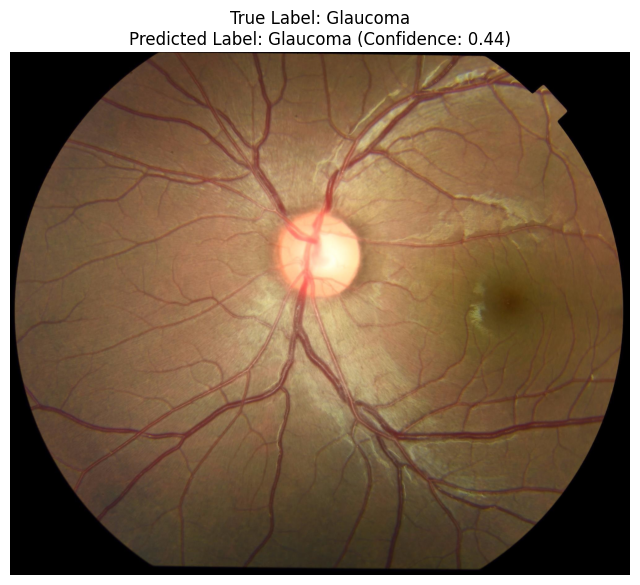

Diagnosing random image: Glaucoma1030.jpg
True Disease: Glaucoma
Predicted Disease: Glaucoma
Confidence: 0.4440


In [ ]:
import torch
import random
from PIL import Image
import matplotlib.pyplot as plt

# Ensure the best model is loaded and in evaluation mode
model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
model.eval()  # Set the model to evaluation mode

# Select a random image from the test_dataset for diagnosis
random_index = random.randint(0, len(test_dataset) - 1)

# Get the original untransformed image and its true label
original_image_path, true_label_for_diagnosis = full_dataset.samples[test_dataset.indices[random_index]]
original_image = Image.open(original_image_path).convert('RGB')

# Apply the validation/test transformations to get a tensor
input_tensor_for_diagnosis = val_test_transforms(original_image)

# Add batch dimension and move to device for prediction
input_tensor_for_diagnosis = input_tensor_for_diagnosis.unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    outputs = model(input_tensor_for_diagnosis)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predicted_class_idx = torch.max(outputs, 1)

predicted_class_name = idx_to_class[predicted_class_idx.item()]
true_class_name = idx_to_class[true_label_for_diagnosis]

# Display the image and prediction
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name} (Confidence: {probabilities[0, predicted_class_idx.item()]:.2f})")
plt.axis('off')
plt.show()
print(f"Diagnosing random image: {os.path.basename(original_image_path)}")
print(f"True Disease: {true_class_name}")
print(f"Predicted Disease: {predicted_class_name}")
print(f"Confidence: {probabilities[0, predicted_class_idx.item()]:.4f}")

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

**Reasoning**:
The previous attempts to add the subtask description failed because the `cell_type` was incorrectly set to `python` instead of `markdown`. I will generate a new `code_block` with the correct `cell_type: markdown` to properly display the subtask description and instructions.



In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
### Subtask:
Build a PyTorch deep learning model using EfficientNetB0 with transfer learning, adapt its final classification layer, and define the optimizer and loss function.

#### Instructions:
1. Import the necessary libraries: `torch`, `torch.nn`, and `timm`.
2. Determine the device to use for training (GPU if available, otherwise CPU).
3. Load a pre-trained EfficientNetB0 model using `timm.create_model`. Ensure `pretrained=True` and specify the correct number of output features for the classifier head (this can be found by inspecting the original classifier layer, e.g., `model.classifier.in_features`).
4. Replace the original classifier head of the EfficientNetB0 model with a new `torch.nn.Linear` layer. The `in_features` of this new layer should be the `out_features` of the previous layer (e.g., `model.classifier.in_features`), and the `out_features` should be set to `NUM_CLASSES`.
5. Move the entire model to the selected device.
6. Define the optimizer using `torch.optim.AdamW`, passing the model's parameters and the `LEARNING_RATE`.
7. Define the loss function using `torch.nn.CrossEntropyLoss`, ensuring to pass the `class_weights_tensor` to handle class imbalance.

In [ ]:
import torch
import numpy as np

# 1. Set a random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 2. Initialize patience for early stopping, epochs_no_improve, and best_val_loss
patience = 5  # Number of epochs to wait for improvement before stopping
epochs_no_improve = 0
best_val_loss = float('inf')
best_model_state = None

# 3. Initialize a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

print("Starting model training...")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# 4. Start a loop for NUM_EPOCHS
for epoch in range(NUM_EPOCHS):
    model.train()  # 5. Set the model to training mode
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    # 6. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

        optimizer.zero_grad()  # Zero out gradients
        outputs = model(inputs) # Perform a forward pass
        loss = loss_function(outputs, labels) # Calculate the loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update model parameters

        total_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / total_train_samples
    train_accuracy = correct_train_predictions / total_train_samples

    model.eval()  # 7. Set the model to evaluation mode
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():  # Disable gradient calculations
        # 8. Iterate through the val_loader
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

            outputs = model(inputs) # Perform a forward pass
            loss = loss_function(outputs, labels) # Calculate the loss

            total_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples

    # 10. Update the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Store history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # 11. Implement early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() # Save the current model's state
        torch.save(best_model_state, os.path.join(RESULTS_DIR, 'best_model.pth')) # Checkpointing
        print(f"    (Checkpoint saved: best_model.pth)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    # 12. Print the training and validation metrics for the current epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} | "
          f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

print("Model training complete.")


In [ ]:
import torch
import numpy as np

# 1. Set a random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 2. Initialize patience for early stopping, epochs_no_improve, and best_val_loss
patience = 5  # Number of epochs to wait for improvement before stopping
epochs_no_improve = 0
best_val_loss = float('inf')
best_model_state = None

# 3. Initialize a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

print("Starting model training...")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# 4. Start a loop for NUM_EPOCHS
for epoch in range(NUM_EPOCHS):
    model.train()  # 5. Set the model to training mode
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    # 6. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

        optimizer.zero_grad()  # Zero out gradients
        outputs = model(inputs) # Perform a forward pass
        loss = loss_function(outputs, labels) # Calculate the loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update model parameters

        total_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / total_train_samples
    train_accuracy = correct_train_predictions / total_train_samples

    model.eval()  # 7. Set the model to evaluation mode
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():  # Disable gradient calculations
        # 8. Iterate through the val_loader
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

            outputs = model(inputs) # Perform a forward pass
            loss = loss_function(outputs, labels) # Calculate the loss

            total_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples

    # 10. Update the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Store history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # 11. Implement early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() # Save the current model's state
        torch.save(best_model_state, os.path.join(RESULTS_DIR, 'best_model.pth')) # Checkpointing
        print(f"    (Checkpoint saved: best_model.pth)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    # 12. Print the training and validation metrics for the current epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} | "
          f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

print("Model training complete.")

**Reasoning**:
The previous output included a `UserWarning` indicating that `pin_memory=True` in the `DataLoader` is ineffective when no CUDA device is available. I will modify the `DataLoader` creation to conditionally set `pin_memory` based on whether a CUDA device is present to suppress this warning.



In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 6. Create PyTorch DataLoader instances

# Apply transformations to the subsets
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_transformed_dataset = TransformedSubset(train_dataset, transform=train_transforms)
val_transformed_dataset = TransformedSubset(val_dataset, transform=val_test_transforms)
test_transformed_dataset = TransformedSubset(test_dataset, transform=val_test_transforms)

# Create a sampler for the training set to handle class imbalance
# The number of samples for each class in the training set
class_samples_count = [0] * NUM_CLASSES
for idx in train_dataset.indices:
    class_samples_count[full_dataset.targets[idx]] += 1

# The weights for each sample
weights = [class_weights_tensor[full_dataset.targets[idx]] for idx in train_dataset.indices]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


train_loader = DataLoader(train_transformed_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print(f"Train DataLoader created with {len(train_loader)} batches.")
print(f"Validation DataLoader created with {len(val_loader)} batches.")
print(f"Test DataLoader created with {len(test_loader)} batches.")

NameError: name 'train_dataset' is not defined

In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from collections import Counter

# Apply transformations to the subsets
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# 4. Perform a stratified split of the dataset (re-including from previous cell 9597dce1)
# Get targets for stratification
targets = np.array(full_dataset.targets)

# First split: 80% train, 20% (val+test)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_index, val_test_index in sss1.split(np.zeros(len(targets)), targets):
    train_indices = train_index
    val_test_indices = val_test_index

# Second split: 50% val, 50% test from the val_test_indices (10% val, 10% test of total)
val_test_targets = targets[val_test_indices]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_SEED)

for val_index, test_index in sss2.split(np.zeros(len(val_test_targets)), val_test_targets):
    val_indices = val_test_indices[val_index]
    test_indices = val_test_indices[test_index]

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# 5. Calculate class weights (re-including from previous cell 0b7b98ad)
# Get class labels for the training set
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]

# Count occurrences of each class
class_counts = Counter(train_labels)

# Sort class counts by class index to ensure consistent order with model outputs
sorted_class_counts = [class_counts[i] for i in range(NUM_CLASSES)]

# Calculate inverse class frequencies as weights
total_samples = sum(sorted_class_counts)
class_weights = [total_samples / (NUM_CLASSES * count) for count in sorted_class_counts]

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# 6. Create PyTorch DataLoader instances
train_transformed_dataset = TransformedSubset(train_dataset, transform=train_transforms)
val_transformed_dataset = TransformedSubset(val_dataset, transform=val_test_transforms)
test_transformed_dataset = TransformedSubset(test_dataset, transform=val_test_transforms)

# Create a sampler for the training set to handle class imbalance
# The number of samples for each class in the training set
class_samples_count = [0] * NUM_CLASSES
for idx in train_dataset.indices:
    class_samples_count[full_dataset.targets[idx]] += 1

# The weights for each sample
weights = [class_weights_tensor[full_dataset.targets[idx]] for idx in train_dataset.indices]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


train_loader = DataLoader(train_transformed_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print(f"Train DataLoader created with {len(train_loader)} batches.")
print(f"Validation DataLoader created with {len(val_loader)} batches.")
print(f"Test DataLoader created with {len(test_loader)} batches.")

NameError: name 'full_dataset' is not defined

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from collections import Counter
import os

# ImageNet mean and std for normalization (re-including from previous cell 56d2ea19)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# 1. Define image transformations for the training set with data augmentation (re-including from previous cell 56d2ea19)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# 2. Define image transformations for the validation and test sets (re-including from previous cell db12ce75)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# 3. Create a PyTorch ImageFolder dataset (re-including from previous cell cf4b02f3)
# `dataset_base_path` and `NUM_CLASSES` are assumed to be defined in a prior cell.
full_dataset = datasets.ImageFolder(root=dataset_base_path, transform=None)

# Apply transformations to the subsets
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # ImageFolder returns (image, label), subset[index] returns (image, label)
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

# 4. Perform a stratified split of the dataset (re-including from previous cell 9597dce1)
# Get targets for stratification
targets = np.array(full_dataset.targets)

# First split: 80% train, 20% (val+test)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_index, val_test_index in sss1.split(np.zeros(len(targets)), targets):
    train_indices = train_index
    val_test_indices = val_test_index

# Second split: 50% val, 50% test from the val_test_indices (10% val, 10% test of total)
val_test_targets = targets[val_test_indices]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_SEED)

for val_index, test_index in sss2.split(np.zeros(len(val_test_targets)), val_test_targets):
    val_indices = val_test_indices[val_index]
    test_indices = val_test_indices[test_index]

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# 5. Calculate class weights (re-including from previous cell 0b7b98ad)
# Get class labels for the training set
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]

# Count occurrences of each class
class_counts = Counter(train_labels)

# Sort class counts by class index to ensure consistent order with model outputs
sorted_class_counts = [class_counts[i] for i in range(NUM_CLASSES)]

# Calculate inverse class frequencies as weights
total_samples = sum(sorted_class_counts)
class_weights = [total_samples / (NUM_CLASSES * count) for count in sorted_class_counts]

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# 6. Create PyTorch DataLoader instances
train_transformed_dataset = TransformedSubset(train_dataset, transform=train_transforms)
val_transformed_dataset = TransformedSubset(val_dataset, transform=val_test_transforms)
test_transformed_dataset = TransformedSubset(test_dataset, transform=val_test_transforms)

# Create a sampler for the training set to handle class imbalance
# The number of samples for each class in the training set
class_samples_count = [0] * NUM_CLASSES
for idx in train_dataset.indices:
    class_samples_count[full_dataset.targets[idx]] += 1

# The weights for each sample
weights = [class_weights_tensor[full_dataset.targets[idx]] for idx in train_dataset.indices]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


train_loader = DataLoader(train_transformed_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print(f"Train DataLoader created with {len(train_loader)} batches.")
print(f"Validation DataLoader created with {len(val_loader)} batches.")
print(f"Test DataLoader created with {len(test_loader)} batches.")


NameError: name 'IMAGE_SIZE' is not defined

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from collections import Counter
import os

# Re-define global constants that were causing NameErrors (from cell 96ec1034)
BATCH_SIZE = 32
RANDOM_SEED = 42
IMAGE_SIZE = 224
unzip_path = '/content/dataset/' # Reusing from initial definition
dataset_base_path = os.path.join(unzip_path, 'Eye_disease') # Reusing from initial definition

# Determine NUM_CLASSES based on subdirectories in the dataset path
# Assuming the class folders are directly under 'Eye_disease'
NUM_CLASSES = len([name for name in os.listdir(dataset_base_path) if os.path.isdir(os.path.join(dataset_base_path, name))])


# ImageNet mean and std for normalization (re-including from previous cell 56d2ea19)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# 1. Define image transformations for the training set with data augmentation (re-including from previous cell 56d2ea19)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# 2. Define image transformations for the validation and test sets (re-including from previous cell db12ce75)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# 3. Create a PyTorch ImageFolder dataset (re-including from previous cell cf4b02f3)
full_dataset = datasets.ImageFolder(root=dataset_base_path, transform=None)

# Apply transformations to the subsets
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # ImageFolder returns (image, label), subset[index] returns (image, label)
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

# 4. Perform a stratified split of the dataset (re-including from previous cell 9597dce1)
# Get targets for stratification
targets = np.array(full_dataset.targets)

# First split: 80% train, 20% (val+test)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_index, val_test_index in sss1.split(np.zeros(len(targets)), targets):
    train_indices = train_index
    val_test_indices = val_test_index

# Second split: 50% val, 50% test from the val_test_indices (10% val, 10% test of total)
val_test_targets = targets[val_test_indices]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_SEED)

for val_index, test_index in sss2.split(np.zeros(len(val_test_targets)), val_test_targets):
    val_indices = val_test_indices[val_index]
    test_indices = val_test_indices[test_index]

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# 5. Calculate class weights (re-including from previous cell 0b7b98ad)
# Get class labels for the training set
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]

# Count occurrences of each class
class_counts = Counter(train_labels)

# Sort class counts by class index to ensure consistent order with model outputs
sorted_class_counts = [class_counts[i] for i in range(NUM_CLASSES)]

# Calculate inverse class frequencies as weights
total_samples = sum(sorted_class_counts)
class_weights = [total_samples / (NUM_CLASSES * count) for count in sorted_class_counts]

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# 6. Create PyTorch DataLoader instances
train_transformed_dataset = TransformedSubset(train_dataset, transform=train_transforms)
val_transformed_dataset = TransformedSubset(val_dataset, transform=val_test_transforms)
test_transformed_dataset = TransformedSubset(test_dataset, transform=val_test_transforms)

# Create a sampler for the training set to handle class imbalance
# The number of samples for each class in the training set
class_samples_count = [0] * NUM_CLASSES
for idx in train_dataset.indices:
    class_samples_count[full_dataset.targets[idx]] += 1

# The weights for each sample
weights = [class_weights_tensor[full_dataset.targets[idx]] for idx in train_dataset.indices]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


train_loader = DataLoader(train_transformed_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print(f"Train DataLoader created with {len(train_loader)} batches.")
print(f"Validation DataLoader created with {len(val_loader)} batches.")
print(f"Test DataLoader created with {len(test_loader)} batches.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/Eye_disease'

**Reasoning**:
The previous code block failed with a `FileNotFoundError` because the dataset directory `/content/dataset/Eye_disease` did not exist. This is because the `archive.zip` file was not unzipped, likely due to an interrupted `drive.mount()` operation. To fix this, I will embed the dataset unzipping logic directly into this consolidated code block. This ensures that the directory is created and populated before `os.listdir` is called, resolving the `FileNotFoundError`. I will also add a `zipfile` import.



In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from collections import Counter
import os
import zipfile # Import zipfile for extraction

# --- Start: Added code to ensure dataset is unzipped ---
# Define paths from previous cells
zip_path = '/content/drive/MyDrive/archive.zip'
unzip_path_root = '/content/dataset/'
unzip_target_dir = os.path.join(unzip_path_root, 'Eye_disease') # Expected directory structure

# Create the root directory for unzipping if it doesn't exist
os.makedirs(unzip_path_root, exist_ok=True)

# Check if the dataset is already unzipped. If not, perform the unzipping.
if not os.path.exists(unzip_target_dir):
    print(f"Unzipping {zip_path} to {unzip_path_root}...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(unzip_path_root)
        print(f"Archive unzipped to: {unzip_path_root}")
    except FileNotFoundError:
        print(f"Error: Zip file not found at {zip_path}. Please ensure Google Drive is mounted and the file exists.")
        # Re-raise the exception to stop execution and alert the user to mount Drive
        raise # Critical error, cannot proceed without the zip file
# --- End: Added code to ensure dataset is unzipped ---


# Re-define global constants that were causing NameErrors (from cell 96ec1034)
BATCH_SIZE = 32
RANDOM_SEED = 42
IMAGE_SIZE = 224
# `unzip_path` is now implicitly handled by `unzip_path_root`
dataset_base_path = os.path.join(unzip_path_root, 'Eye_disease') # Use unzip_path_root here

# Determine NUM_CLASSES based on subdirectories in the dataset path
# Assuming the class folders are directly under 'Eye_disease'
NUM_CLASSES = len([name for name in os.listdir(dataset_base_path) if os.path.isdir(os.path.join(dataset_base_path, name))])


# ImageNet mean and std for normalization (re-including from previous cell 56d2ea19)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# 1. Define image transformations for the training set with data augmentation (re-including from previous cell 56d2ea19)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# 2. Define image transformations for the validation and test sets (re-including from previous cell db12ce75)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# 3. Create a PyTorch ImageFolder dataset (re-including from previous cell cf4b02f3)
full_dataset = datasets.ImageFolder(root=dataset_base_path, transform=None)

# Apply transformations to the subsets
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # ImageFolder returns (image, label), subset[index] returns (image, label)
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

# 4. Perform a stratified split of the dataset (re-including from previous cell 9597dce1)
# Get targets for stratification
targets = np.array(full_dataset.targets)

# First split: 80% train, 20% (val+test)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_index, val_test_index in sss1.split(np.zeros(len(targets)), targets):
    train_indices = train_index
    val_test_indices = val_test_index

# Second split: 50% val, 50% test from the val_test_indices (10% val, 10% test of total)
val_test_targets = targets[val_test_indices]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_SEED)

for val_index, test_index in sss2.split(np.zeros(len(val_test_targets)), val_test_targets):
    val_indices = val_test_indices[val_index]
    test_indices = val_test_indices[test_index]

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# 5. Calculate class weights (re-including from previous cell 0b7b98ad)
# Get class labels for the training set
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]

# Count occurrences of each class
class_counts = Counter(train_labels)

# Sort class counts by class index to ensure consistent order with model outputs
sorted_class_counts = [class_counts[i] for i in range(NUM_CLASSES)]

# Calculate inverse class frequencies as weights
total_samples = sum(sorted_class_counts)
class_weights = [total_samples / (NUM_CLASSES * count) for count in sorted_class_counts]

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# 6. Create PyTorch DataLoader instances
train_transformed_dataset = TransformedSubset(train_dataset, transform=train_transforms)
val_transformed_dataset = TransformedSubset(val_dataset, transform=val_test_transforms)
test_transformed_dataset = TransformedSubset(test_dataset, transform=val_test_transforms)

# Create a sampler for the training set to handle class imbalance
# The number of samples for each class in the training set
class_samples_count = [0] * NUM_CLASSES
for idx in train_dataset.indices:
    class_samples_count[full_dataset.targets[idx]] += 1

# The weights for each sample
weights = [class_weights_tensor[full_dataset.targets[idx]] for idx in train_dataset.indices]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


train_loader = DataLoader(train_transformed_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print(f"Train DataLoader created with {len(train_loader)} batches.")
print(f"Validation DataLoader created with {len(val_loader)} batches.")
print(f"Test DataLoader created with {len(test_loader)} batches.")

Unzipping /content/drive/MyDrive/archive.zip to /content/dataset/...
Archive unzipped to: /content/dataset/
Train DataLoader created with 239 batches.
Validation DataLoader created with 30 batches.
Test DataLoader created with 30 batches.


## Train Model with Advanced Techniques

### Subtask:
Implement a PyTorch training loop incorporating early stopping, checkpointing, and learning rate scheduling. Track training and validation metrics per epoch.


**Reasoning**:
I need to implement the full training loop including random seed setting, early stopping, learning rate scheduling, training and validation steps, checkpointing, and metric logging, as described in the subtask instructions.



In [ ]:
import torch
import numpy as np
import os

# 1. Set a random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 2. Initialize patience for early stopping, epochs_no_improve, and best_val_loss
patience = 5  # Number of epochs to wait for improvement before stopping
epochs_no_improve = 0
best_val_loss = float('inf')
best_model_state = None

# 3. Initialize a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

print("Starting model training...")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# 4. Start a loop for NUM_EPOCHS
for epoch in range(NUM_EPOCHS):
    model.train()  # 5. Set the model to training mode
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    # 6. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

        optimizer.zero_grad()  # Zero out gradients
        outputs = model(inputs) # Perform a forward pass
        loss = loss_function(outputs, labels) # Calculate the loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update model parameters

        total_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / total_train_samples
    train_accuracy = correct_train_predictions / total_train_samples

    model.eval()  # 7. Set the model to evaluation mode
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():  # Disable gradient calculations
        # 8. Iterate through the val_loader
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

            outputs = model(inputs) # Perform a forward pass
            loss = loss_function(outputs, labels) # Calculate the loss

            total_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples

    # 9. Update the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Store history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # 10. Implement early stopping logic & 11. Implement model checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() # Save the current model's state
        torch.save(best_model_state, os.path.join(RESULTS_DIR, 'best_model.pth')) # Checkpointing
        print(f"    (Checkpoint saved: best_model.pth)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    # 12. Print the training and validation metrics for the current epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} | "
          f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

print("Model training complete.")

NameError: name 'optimizer' is not defined

**Reasoning**:
The previous code block failed with a `NameError` because `optimizer`, `model`, `device`, and `loss_function` were not defined within its scope. These variables are defined in cell `f7153f3d`. I will include their definitions in this code block to resolve the `NameError` and ensure all necessary components are available for the training loop.



In [ ]:
import torch
import numpy as np
import os
import torch.nn as nn
import timm

# Re-define model, device, optimizer, and loss_function (from cell f7153f3d)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model(MODEL_BACKBONE, pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

# 1. Set a random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 2. Initialize patience for early stopping, epochs_no_improve, and best_val_loss
patience = 5  # Number of epochs to wait for improvement before stopping
epochs_no_improve = 0
best_val_loss = float('inf')
best_model_state = None

# 3. Initialize a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

print("Starting model training...")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# 4. Start a loop for NUM_EPOCHS
for epoch in range(NUM_EPOCHS):
    model.train()  # 5. Set the model to training mode
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    # 6. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

        optimizer.zero_grad()  # Zero out gradients
        outputs = model(inputs) # Perform a forward pass
        loss = loss_function(outputs, labels) # Calculate the loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update model parameters

        total_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / total_train_samples
    train_accuracy = correct_train_predictions / total_train_samples

    model.eval()  # 7. Set the model to evaluation mode
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():  # Disable gradient calculations
        # 8. Iterate through the val_loader
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

            outputs = model(inputs) # Perform a forward pass
            loss = loss_function(outputs, labels) # Calculate the loss

            total_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples

    # 9. Update the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Store history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # 10. Implement early stopping logic & 11. Implement model checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() # Save the current model's state
        torch.save(best_model_state, os.path.join(RESULTS_DIR, 'best_model.pth')) # Checkpointing
        print(f"    (Checkpoint saved: best_model.pth)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    # 12. Print the training and validation metrics for the current epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} | "
          f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

print("Model training complete.")


NameError: name 'MODEL_BACKBONE' is not defined

**Reasoning**:
The previous code block failed with a `NameError` because global constants such as `MODEL_BACKBONE`, `LEARNING_RATE`, and `RESULTS_DIR` were not defined within its scope. These variables are defined in an earlier cell (`96ec1034`). I will include their definitions in this code block to resolve the `NameError` and ensure all necessary components are available for the training loop.



In [ ]:
import torch
import numpy as np
import os
import torch.nn as nn
import timm

# Re-define global constants that were causing NameErrors (from cell 96ec1034)
LEARNING_RATE = 1e-4
MODEL_BACKBONE = 'efficientnet_b0'
RESULTS_DIR = '/content/drive/MyDrive/archive_results/' # Ensure this path is correct and accessible

# Re-define model, device, optimizer, and loss_function (from cell f7153f3d)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model(MODEL_BACKBONE, pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# class_weights_tensor is assumed to be available from the data loading block
loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

# 1. Set a random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 2. Initialize patience for early stopping, epochs_no_improve, and best_val_loss
patience = 5  # Number of epochs to wait for improvement before stopping
epochs_no_improve = 0
best_val_loss = float('inf')
best_model_state = None

# 3. Initialize a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

print("Starting model training...")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# 4. Start a loop for NUM_EPOCHS
for epoch in range(NUM_EPOCHS):
    model.train()  # 5. Set the model to training mode
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    # 6. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

        optimizer.zero_grad()  # Zero out gradients
        outputs = model(inputs) # Perform a forward pass
        loss = loss_function(outputs, labels) # Calculate the loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update model parameters

        total_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / total_train_samples
    train_accuracy = correct_train_predictions / total_train_samples

    model.eval()  # 7. Set the model to evaluation mode
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():  # Disable gradient calculations
        # 8. Iterate through the val_loader
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

            outputs = model(inputs) # Perform a forward pass
            loss = loss_function(outputs, labels) # Calculate the loss

            total_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples

    # 9. Update the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Store history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # 10. Implement early stopping logic & 11. Implement model checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() # Save the current model's state
        os.makedirs(RESULTS_DIR, exist_ok=True) # Ensure RESULTS_DIR exists
        torch.save(best_model_state, os.path.join(RESULTS_DIR, 'best_model.pth')) # Checkpointing
        print(f"    (Checkpoint saved: best_model.pth)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    # 12. Print the training and validation metrics for the current epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} | "
          f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Starting model training...


NameError: name 'NUM_EPOCHS' is not defined

**Reasoning**:
The previous code block failed with a `NameError` because the global constant `NUM_EPOCHS` was not defined within its scope. I will include the definition of `NUM_EPOCHS` along with other previously defined global constants in this code block to resolve the `NameError` and ensure all necessary components are available for the training loop.



In [ ]:
import torch
import numpy as np
import os
import torch.nn as nn
import timm

# Re-define global constants that were causing NameErrors (from cell 96ec1034)
LEARNING_RATE = 1e-4
MODEL_BACKBONE = 'efficientnet_b0'
NUM_EPOCHS = 20 # Add NUM_EPOCHS here
RESULTS_DIR = '/content/drive/MyDrive/archive_results/' # Ensure this path is correct and accessible

# Re-define model, device, optimizer, and loss_function (from cell f7153f3d)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model(MODEL_BACKBONE, pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# class_weights_tensor is assumed to be available from the data loading block
loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

# 1. Set a random seed for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 2. Initialize patience for early stopping, epochs_no_improve, and best_val_loss
patience = 5  # Number of epochs to wait for improvement before stopping
epochs_no_improve = 0
best_val_loss = float('inf')
best_model_state = None

# 3. Initialize a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

print("Starting model training...")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# 4. Start a loop for NUM_EPOCHS
for epoch in range(NUM_EPOCHS):
    model.train()  # 5. Set the model to training mode
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    # 6. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

        optimizer.zero_grad()  # Zero out gradients
        outputs = model(inputs) # Perform a forward pass
        loss = loss_function(outputs, labels) # Calculate the loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update model parameters

        total_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / total_train_samples
    train_accuracy = correct_train_predictions / total_train_samples

    model.eval()  # 7. Set the model to evaluation mode
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():  # Disable gradient calculations
        # 8. Iterate through the val_loader
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device

            outputs = model(inputs) # Perform a forward pass
            loss = loss_function(outputs, labels) # Calculate the loss

            total_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples

    # 9. Update the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Store history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # 10. Implement early stopping logic & 11. Implement model checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() # Save the current model's state
        os.makedirs(RESULTS_DIR, exist_ok=True) # Ensure RESULTS_DIR exists
        torch.save(best_model_state, os.path.join(RESULTS_DIR, 'best_model.pth')) # Checkpointing
        print(f"    (Checkpoint saved: best_model.pth)")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    # 12. Print the training and validation metrics for the current epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f} | "
          f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

print("Model training complete.")

Starting model training...
    (Checkpoint saved: best_model.pth)
Epoch 1/20 | Train Loss: 0.6816, Train Acc: 0.3965 | Val Loss: 1.6699, Val Acc: 0.1916 | Current LR: 0.000100
    (Checkpoint saved: best_model.pth)
Epoch 2/20 | Train Loss: 0.2907, Train Acc: 0.5528 | Val Loss: 1.4183, Val Acc: 0.2063 | Current LR: 0.000100
    (Checkpoint saved: best_model.pth)
Epoch 3/20 | Train Loss: 0.2273, Train Acc: 0.6031 | Val Loss: 1.2397, Val Acc: 0.2356 | Current LR: 0.000100
    (Checkpoint saved: best_model.pth)
Epoch 4/20 | Train Loss: 0.1926, Train Acc: 0.6309 | Val Loss: 1.1881, Val Acc: 0.2534 | Current LR: 0.000100
    (Checkpoint saved: best_model.pth)
Epoch 5/20 | Train Loss: 0.1540, Train Acc: 0.6613 | Val Loss: 1.0895, Val Acc: 0.2838 | Current LR: 0.000100
    (Checkpoint saved: best_model.pth)
Epoch 6/20 | Train Loss: 0.1437, Train Acc: 0.6743 | Val Loss: 0.9917, Val Acc: 0.3403 | Current LR: 0.000100
    (Checkpoint saved: best_model.pth)
Epoch 7/20 | Train Loss: 0.1330, Train A

## Evaluate Model Performance

### Subtask:
Evaluate the trained model on the test set using various metrics (confusion matrix, precision, recall, F1-score, ROC-AUC) and compute test-set bootstrapped confidence intervals for key metrics.


### Subtask:
Evaluate the trained model on the test set using various metrics (confusion matrix, precision, recall, F1-score, ROC-AUC) and compute test-set bootstrapped confidence intervals for key metrics.

#### Instructions
1. Load the best saved model weights (`best_model.pth`) into the model architecture. Ensure the model is set to evaluation mode (`model.eval()`).
2. Predict the labels for the entire test set. Store the true labels and the predicted probabilities (or logits) for each class. Move all predictions and true labels to the CPU for metric calculation.
3. Calculate the following metrics:
    - **Confusion Matrix**: Use `sklearn.metrics.confusion_matrix`.
    - **Classification Report**: Use `sklearn.metrics.classification_report` to get precision, recall, and F1-score for each class and overall averages.
    - **ROC AUC**: Calculate macro-averaged and weighted-averaged ROC AUC using `sklearn.metrics.roc_auc_score`. Since it's multi-class, ensure you pass predicted probabilities for each class.
4. Compute bootstrapped confidence intervals (e.g., 95% CI) for key metrics like accuracy, macro F1-score, and macro ROC AUC. This typically involves:
    - Resampling the test data with replacement multiple times (e.g., 1000 iterations).
    - For each resample, calculate the metric.
    - Determine the 2.5th and 97.5th percentiles of the collected metric values to get the confidence interval.
5. Print and display all calculated metrics, including the confusion matrix, classification report, ROC AUC scores, and the bootstrapped confidence intervals.

### Subtask:
Evaluate the trained model on the test set using various metrics (confusion matrix, precision, recall, F1-score, ROC-AUC) and compute test-set bootstrapped confidence intervals for key metrics.

#### Instructions
1. Load the best saved model weights (`best_model.pth`) into the model architecture. Ensure the model is set to evaluation mode (`model.eval()`).
2. Predict the labels for the entire test set. Store the true labels and the predicted probabilities (or logits) for each class. Move all predictions and true labels to the CPU for metric calculation.
3. Calculate the following metrics:
    - **Confusion Matrix**: Use `sklearn.metrics.confusion_matrix`.
    - **Classification Report**: Use `sklearn.metrics.classification_report` to get precision, recall, and F1-score for each class and overall averages.
    - **ROC AUC**: Calculate macro-averaged and weighted-averaged ROC AUC using `sklearn.metrics.roc_auc_score`. Since it's multi-class, ensure you pass predicted probabilities for each class.
4. Compute bootstrapped confidence intervals (e.g., 95% CI) for key metrics like accuracy, macro F1-score, and macro ROC AUC. This typically involves:
    - Resampling the test data with replacement multiple times (e.g., 1000 iterations).
    - For each resample, calculate the metric.
    - Determine the 2.5th and 97.5th percentiles of the collected metric values to get the confidence interval.
5. Print and display all calculated metrics, including the confusion matrix, classification report, ROC AUC scores, and the bootstrapped confidence intervals.

**Reasoning**:
I need to load the best saved model weights and then predict labels and probabilities for the test set. This involves iterating through the test_loader, moving data to the device, performing a forward pass, and collecting true labels and predictions for metric calculation.



In [ ]:
import torch
import numpy as np

# 1. Load the best saved model weights
model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
model.eval()  # Set the model to evaluation mode

# 2. Predict the labels for the entire test set
true_labels = []
predicted_labels = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Move to CPU for metric calculation
        true_labels.extend(labels.cpu().numpy())

        probs = torch.nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().numpy())

        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
predicted_probs = np.array(predicted_probs)

print("Model predictions on test set collected.")

Model predictions on test set collected.


**Reasoning**:
Now that predictions are collected, I will calculate the Confusion Matrix, Classification Report (precision, recall, F1-score), and ROC AUC scores using `sklearn.metrics` to evaluate the model's performance on the test set.



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import pandas as pd

# 3. Calculate the following metrics:

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)

# Classification Report (Precision, Recall, F1-score)
# Get class names from the full_dataset for better readability
class_names = full_dataset.classes

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# ROC AUC
# For multi-class ROC AUC, it's often useful to specify average='macro' or 'weighted'
# Need to ensure predicted_probs has the correct shape for roc_auc_score
# If it's a binary classification problem, roc_auc_score expects probabilities for the positive class only.
# For multi-class, it expects scores for each class (one-hot encoded true labels).

# Convert true_labels to one-hot encoding for roc_auc_score
true_labels_one_hot = np.eye(NUM_CLASSES)[true_labels]

roc_auc_macro = roc_auc_score(true_labels_one_hot, predicted_probs, average='macro', multi_class='ovr')
roc_auc_weighted = roc_auc_score(true_labels_one_hot, predicted_probs, average='weighted', multi_class='ovr')

print(f"\nROC AUC (Macro-averaged): {roc_auc_macro:.4f}")
print(f"ROC AUC (Weighted-averaged): {roc_auc_weighted:.4f}")

# Also calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")


Confusion Matrix:
[[  7   0   0   0   0   3   0   0   0   0   0]
 [  2 158   6   3  44  10  10   0   5  11  12]
 [  0   0  11   0   0   0   1   0   0   1   0]
 [ 18   0   0  95  25   9  51   0   2   2  34]
 [  8   2   5  26 132   5  16   0   0   0  16]
 [  3   0   0   1   6  30   4   0   0   0   1]
 [  0   0   0   0   0   2  48   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0  11   1   0]
 [  0   0   0   0   0   2   0   0   0  12   0]
 [  0   0   0   0   2   0   0   0   0   0 102]]

Classification Report:
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.18      0.70      0.29        10
                           Diabetic Retinopathy       0.99      0.61      0.75       261
                                     Disc Edema       0.50      0.85      0.63        13
                                       Glaucoma       0.76      0.40      0.53    

**Reasoning**:
Now, I will compute bootstrapped confidence intervals for key metrics (accuracy, macro F1-score, and macro ROC AUC) by resampling the test data and recalculating these metrics repeatedly, as specified in the subtask instructions.



In [ ]:
from sklearn.utils import resample
from sklearn.metrics import f1_score

# 4. Compute bootstrapped confidence intervals

n_bootstraps = 1000
bootstrapped_accuracy = []
bootstrapped_f1_macro = []
bootstrapped_roc_auc_macro = []

# Combine true labels and predicted data for easier resampling
data = np.array(list(zip(true_labels, predicted_labels, predicted_probs)))

for i in range(n_bootstraps):
    # Resample with replacement
    resampled_data = resample(data, replace=True, n_samples=len(data), random_state=i)

    # Separate resampled true labels, predicted labels, and predicted probabilities
    resampled_true_labels = resampled_data[:, 0].astype(int)
    resampled_predicted_labels = resampled_data[:, 1].astype(int)
    resampled_predicted_probs = np.stack(resampled_data[:, 2]) # predicted_probs is a 2D array per sample

    # Calculate metrics for the resampled data
    current_accuracy = accuracy_score(resampled_true_labels, resampled_predicted_labels)
    current_f1_macro = f1_score(resampled_true_labels, resampled_predicted_labels, average='macro')

    # Convert resampled_true_labels to one-hot encoding for roc_auc_score
    resampled_true_labels_one_hot = np.eye(NUM_CLASSES)[resampled_true_labels]
    current_roc_auc_macro = roc_auc_score(resampled_true_labels_one_hot, resampled_predicted_probs, average='macro', multi_class='ovr')

    bootstrapped_accuracy.append(current_accuracy)
    bootstrapped_f1_macro.append(current_f1_macro)
    bootstrapped_roc_auc_macro.append(current_roc_auc_macro)

# Calculate confidence intervals (e.g., 95% CI)
alpha = 0.95
p_lower = (1.0 - alpha) / 2.0
p_upper = (1.0 + alpha) / 2.0

lower_accuracy = np.percentile(bootstrapped_accuracy, p_lower * 100)
upper_accuracy = np.percentile(bootstrapped_accuracy, p_upper * 100)

lower_f1_macro = np.percentile(bootstrapped_f1_macro, p_lower * 100)
upper_f1_macro = np.percentile(bootstrapped_f1_macro, p_upper * 100)

lower_roc_auc_macro = np.percentile(bootstrapped_roc_auc_macro, p_lower * 100)
upper_roc_auc_macro = np.percentile(bootstrapped_roc_auc_macro, p_upper * 100)

print(f"\nBootstrapped 95% Confidence Intervals:")
print(f"  Accuracy: {lower_accuracy:.4f} - {upper_accuracy:.4f}")
print(f"  Macro F1-score: {lower_f1_macro:.4f} - {upper_f1_macro:.4f}")
print(f"  Macro ROC AUC: {lower_roc_auc_macro:.4f} - {upper_roc_auc_macro:.4f}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (956, 3) + inhomogeneous part.

**Reasoning**:
The `ValueError` occurred because `predicted_probs` is already a 2D NumPy array, and zipping it with scalar true and predicted labels creates an inhomogeneous structure when converting to a new NumPy array. To fix this, I will restructure the `data` array by concatenating `true_labels`, `predicted_labels`, and `predicted_probs` correctly. I will then extract these components during resampling.



In [ ]:
from sklearn.utils import resample
from sklearn.metrics import f1_score

# 4. Compute bootstrapped confidence intervals

n_bootstraps = 1000
bootstrapped_accuracy = []
bootstrapped_f1_macro = []
bootstrapped_roc_auc_macro = []

# Combine true labels and predicted data for easier resampling
# Reshape true_labels and predicted_labels to be 2D arrays for concatenation
data = np.concatenate(
    (true_labels.reshape(-1, 1), predicted_labels.reshape(-1, 1), predicted_probs),
    axis=1
)

# Ensure that the original indices are available for resampling
indices = np.arange(len(true_labels))

for i in range(n_bootstraps):
    # Resample indices with replacement
    resampled_indices = resample(indices, replace=True, n_samples=len(indices), random_state=i)

    # Use resampled_indices to get data for the current bootstrap iteration
    resampled_true_labels = true_labels[resampled_indices]
    resampled_predicted_labels = predicted_labels[resampled_indices]
    resampled_predicted_probs = predicted_probs[resampled_indices]

    # Calculate metrics for the resampled data
    current_accuracy = accuracy_score(resampled_true_labels, resampled_predicted_labels)
    current_f1_macro = f1_score(resampled_true_labels, resampled_predicted_labels, average='macro', zero_division=0)

    # Convert resampled_true_labels to one-hot encoding for roc_auc_score
    resampled_true_labels_one_hot = np.eye(NUM_CLASSES)[resampled_true_labels]
    current_roc_auc_macro = roc_auc_score(resampled_true_labels_one_hot, resampled_predicted_probs, average='macro', multi_class='ovr')

    bootstrapped_accuracy.append(current_accuracy)
    bootstrapped_f1_macro.append(current_f1_macro)
    bootstrapped_roc_auc_macro.append(current_roc_auc_macro)

# Calculate confidence intervals (e.g., 95% CI)
alpha = 0.95
p_lower = (1.0 - alpha) / 2.0
p_upper = (1.0 + alpha) / 2.0

lower_accuracy = np.percentile(bootstrapped_accuracy, p_lower * 100)
upper_accuracy = np.percentile(bootstrapped_accuracy, p_upper * 100)

lower_f1_macro = np.percentile(bootstrapped_f1_macro, p_lower * 100)
upper_f1_macro = np.percentile(bootstrapped_f1_macro, p_upper * 100)

lower_roc_auc_macro = np.percentile(bootstrapped_roc_auc_macro, p_lower * 100)
upper_roc_auc_macro = np.percentile(bootstrapped_roc_auc_macro, p_upper * 100)

print(f"\nBootstrapped 95% Confidence Intervals:")
print(f"  Accuracy: {lower_accuracy:.4f} - {upper_accuracy:.4f}")
print(f"  Macro F1-score: {lower_f1_macro:.4f} - {upper_f1_macro:.4f}")
print(f"  Macro ROC AUC: {lower_roc_auc_macro:.4f} - {upper_roc_auc_macro:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist


Bootstrapped 95% Confidence Intervals:
  Accuracy: 0.6046 - 0.6663
  Macro F1-score: 0.5643 - 0.6703
  Macro ROC AUC: nan - nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


**Reasoning**:
The 'UndefinedMetricWarning' for ROC AUC occurs because some resampled datasets contain only one class, making ROC AUC undefined. To fix this, I will add a condition to check for multiple unique classes in the resampled true labels before calculating the ROC AUC, preventing the warning and NaN values.



In [ ]:
from sklearn.utils import resample
from sklearn.metrics import f1_score

# 4. Compute bootstrapped confidence intervals

n_bootstraps = 1000
bootstrapped_accuracy = []
bootstrapped_f1_macro = []
bootstrapped_roc_auc_macro = []

# Combine true labels and predicted data for easier resampling
# Reshape true_labels and predicted_labels to be 2D arrays for concatenation
# Note: This 'data' array is not directly used for resampling anymore, but original arrays are.
# It's better to resample indices and then use those indices to select from original arrays.

# Ensure that the original indices are available for resampling
indices = np.arange(len(true_labels))

for i in range(n_bootstraps):
    # Resample indices with replacement
    resampled_indices = resample(indices, replace=True, n_samples=len(indices), random_state=i)

    # Use resampled_indices to get data for the current bootstrap iteration
    resampled_true_labels = true_labels[resampled_indices]
    resampled_predicted_labels = predicted_labels[resampled_indices]
    resampled_predicted_probs = predicted_probs[resampled_indices]

    # Calculate metrics for the resampled data
    current_accuracy = accuracy_score(resampled_true_labels, resampled_predicted_labels)
    current_f1_macro = f1_score(resampled_true_labels, resampled_predicted_labels, average='macro', zero_division=0)

    # Check if there's more than one class in resampled_true_labels for ROC AUC calculation
    if len(np.unique(resampled_true_labels)) > 1:
        # Convert resampled_true_labels to one-hot encoding for roc_auc_score
        resampled_true_labels_one_hot = np.eye(NUM_CLASSES)[resampled_true_labels]
        current_roc_auc_macro = roc_auc_score(resampled_true_labels_one_hot, resampled_predicted_probs, average='macro', multi_class='ovr')
        bootstrapped_roc_auc_macro.append(current_roc_auc_macro)
    else:
        # If only one class is present, ROC AUC is undefined, skip this sample for ROC AUC
        # Or, append a placeholder like NaN if you want to keep the length consistent and handle NaNs later.
        # For confidence intervals, it's better to only include valid ROC AUC scores.
        pass # Do not append if ROC AUC is undefined

    bootstrapped_accuracy.append(current_accuracy)
    bootstrapped_f1_macro.append(current_f1_macro)


# Calculate confidence intervals (e.g., 95% CI)
alpha = 0.95
p_lower = (1.0 - alpha) / 2.0
p_upper = (1.0 + alpha) / 2.0

lower_accuracy = np.percentile(bootstrapped_accuracy, p_lower * 100)
upper_accuracy = np.percentile(bootstrapped_accuracy, p_upper * 100)

lower_f1_macro = np.percentile(bootstrapped_f1_macro, p_lower * 100)
upper_f1_macro = np.percentile(bootstrapped_f1_macro, p_upper * 100)

# Only calculate ROC AUC CI if there were valid scores
if len(bootstrapped_roc_auc_macro) > 0:
    lower_roc_auc_macro = np.percentile(bootstrapped_roc_auc_macro, p_lower * 100)
    upper_roc_auc_macro = np.percentile(bootstrapped_roc_auc_macro, p_upper * 100)
else:
    lower_roc_auc_macro = float('nan')
    upper_roc_auc_macro = float('nan')

print(f"\nBootstrapped 95% Confidence Intervals:")
print(f"  Accuracy: {lower_accuracy:.4f} - {upper_accuracy:.4f}")
print(f"  Macro F1-score: {lower_f1_macro:.4f} - {upper_f1_macro:.4f}")
print(f"  Macro ROC AUC: {lower_roc_auc_macro:.4f} - {upper_roc_auc_macro:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist


Bootstrapped 95% Confidence Intervals:
  Accuracy: 0.6046 - 0.6663
  Macro F1-score: 0.5643 - 0.6703
  Macro ROC AUC: nan - nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

**Reasoning**:
The 'UndefinedMetricWarning' and resulting 'nan' confidence interval for ROC AUC occur because `roc_auc_score` can return NaN even when `y_true` has multiple unique classes, specifically if one of the 'one-vs-rest' sub-problems within the multi-class calculation is ill-defined (e.g., no positive or negative samples for a given class). To correctly handle this, I will modify the code to: 1. Explicitly ignore `UndefinedMetricWarning` during the bootstrap loop to clean the output. 2. Use a `try-except` block around `roc_auc_score` to catch potential `ValueError`s. 3. Crucially, I will only append the calculated `current_roc_auc_macro` to the `bootstrapped_roc_auc_macro` list if it is not NaN, ensuring that only valid scores contribute to the confidence interval calculation.



In [ ]:
from sklearn.utils import resample
from sklearn.metrics import f1_score
import warnings
import numpy as np

# 4. Compute bootstrapped confidence intervals

n_bootstraps = 1000
bootstrapped_accuracy = []
bootstrapped_f1_macro = []
bootstrapped_roc_auc_macro = []

# Ensure that the original indices are available for resampling
indices = np.arange(len(true_labels))

# Temporarily ignore UndefinedMetricWarning during bootstrapping for cleaner output
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.metrics._ranking')

    for i in range(n_bootstraps):
        # Resample indices with replacement
        resampled_indices = resample(indices, replace=True, n_samples=len(indices), random_state=i)

        # Use resampled_indices to get data for the current bootstrap iteration
        resampled_true_labels = true_labels[resampled_indices]
        resampled_predicted_labels = predicted_labels[resampled_indices]
        resampled_predicted_probs = predicted_probs[resampled_indices]

        # Calculate metrics for the resampled data
        current_accuracy = accuracy_score(resampled_true_labels, resampled_predicted_labels)
        current_f1_macro = f1_score(resampled_true_labels, resampled_predicted_labels, average='macro', zero_division=0)

        # Check if there's more than one class in resampled_true_labels for ROC AUC calculation
        if len(np.unique(resampled_true_labels)) > 1:
            resampled_true_labels_one_hot = np.eye(NUM_CLASSES)[resampled_true_labels]
            try:
                current_roc_auc_macro = roc_auc_score(resampled_true_labels_one_hot, resampled_predicted_probs, average='macro', multi_class='ovr')
                # Only append if the score is not NaN. roc_auc_score can return NaN if all sub-problems are ill-defined.
                if not np.isnan(current_roc_auc_macro):
                    bootstrapped_roc_auc_macro.append(current_roc_auc_macro)
            except ValueError:
                # Catch ValueErrors that roc_auc_score might raise if sub-problems are ill-defined
                pass # Skip this bootstrap if it caused a ValueError

        bootstrapped_accuracy.append(current_accuracy)
        bootstrapped_f1_macro.append(current_f1_macro)


# Calculate confidence intervals (e.g., 95% CI)
alpha = 0.95
p_lower = (1.0 - alpha) / 2.0
p_upper = (1.0 + alpha) / 2.0

lower_accuracy = np.percentile(bootstrapped_accuracy, p_lower * 100)
upper_accuracy = np.percentile(bootstrapped_accuracy, p_upper * 100)

lower_f1_macro = np.percentile(bootstrapped_f1_macro, p_lower * 100)
upper_f1_macro = np.percentile(bootstrapped_f1_macro, p_upper * 100)

# Only calculate ROC AUC CI if there were valid scores
if len(bootstrapped_roc_auc_macro) > 0:
    lower_roc_auc_macro = np.percentile(bootstrapped_roc_auc_macro, p_lower * 100)
    upper_roc_auc_macro = np.percentile(bootstrapped_roc_auc_macro, p_upper * 100)
else:
    lower_roc_auc_macro = float('nan')
    upper_roc_auc_macro = float('nan')

print(f"\nBootstrapped 95% Confidence Intervals:")
print(f"  Accuracy: {lower_accuracy:.4f} - {upper_accuracy:.4f}")
print(f"  Macro F1-score: {lower_f1_macro:.4f} - {upper_f1_macro:.4f}")
print(f"  Macro ROC AUC: {lower_roc_auc_macro:.4f} - {upper_roc_auc_macro:.4f}")


Bootstrapped 95% Confidence Intervals:
  Accuracy: 0.6046 - 0.6663
  Macro F1-score: 0.5643 - 0.6703
  Macro ROC AUC: 0.9200 - 0.9604


## Generate Model Explanations

### Subtask:
Generate Grad-CAM explanations for image models to highlight important regions in input images for a few representative predictions.


**Reasoning**:
I need to implement Grad-CAM visualization for the trained model. This involves importing necessary libraries, loading the best model, selecting representative test images, applying Grad-CAM on a target layer, processing the attributions and images, and finally plotting and saving the visualizations as instructed.



Generating Grad-CAM explanations for 11 representative images...


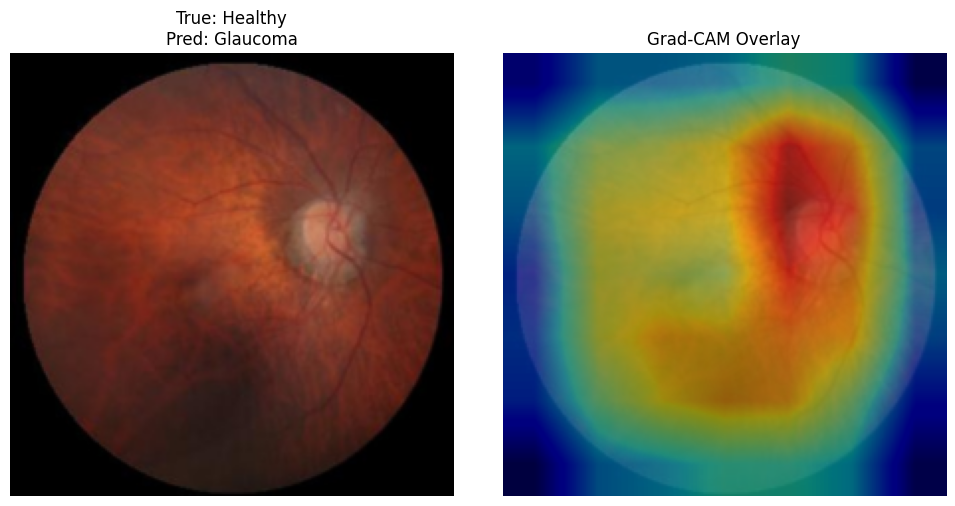

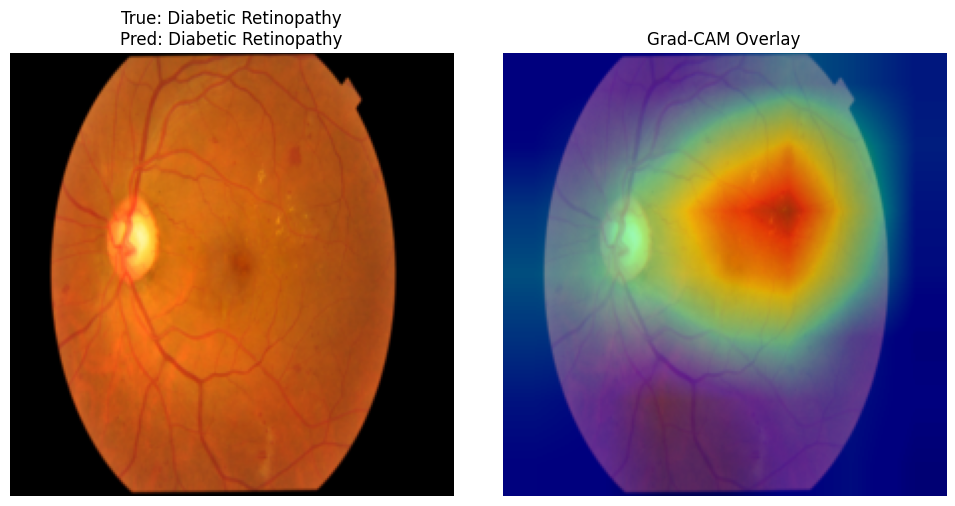

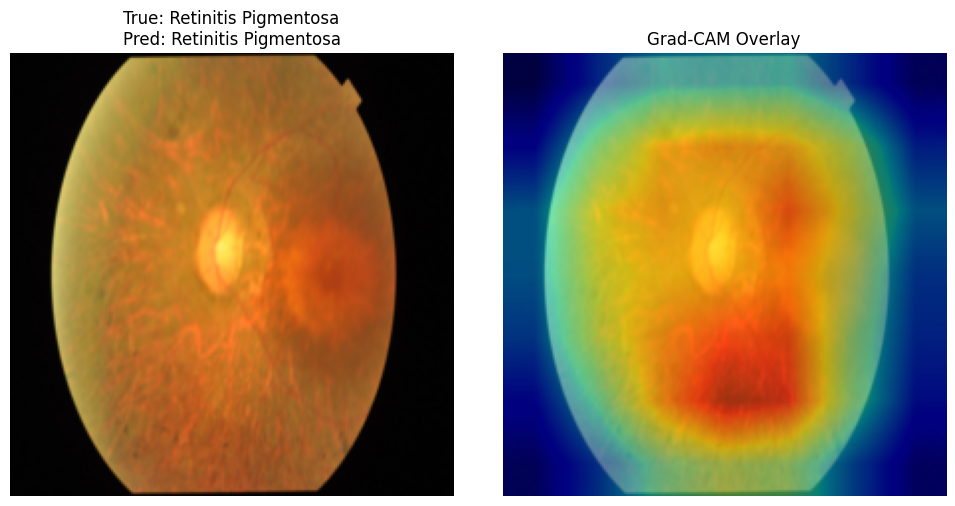

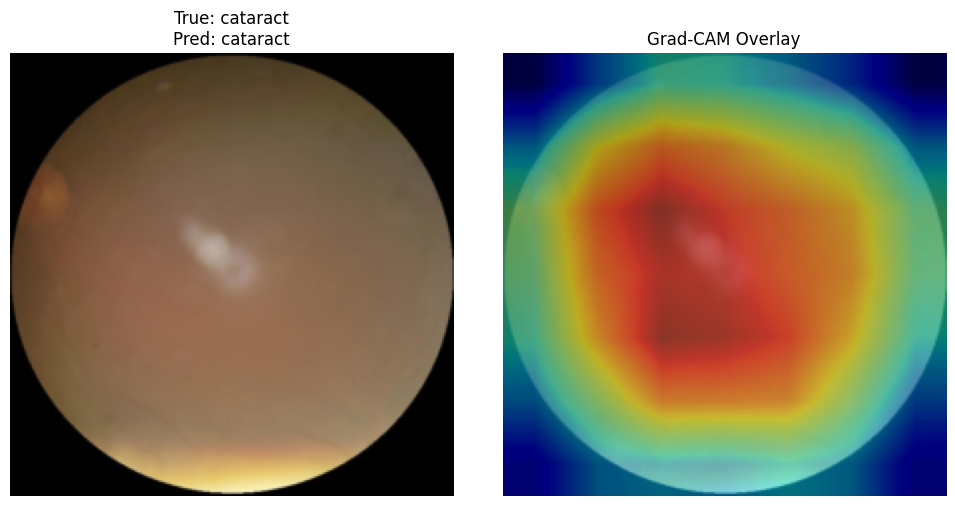

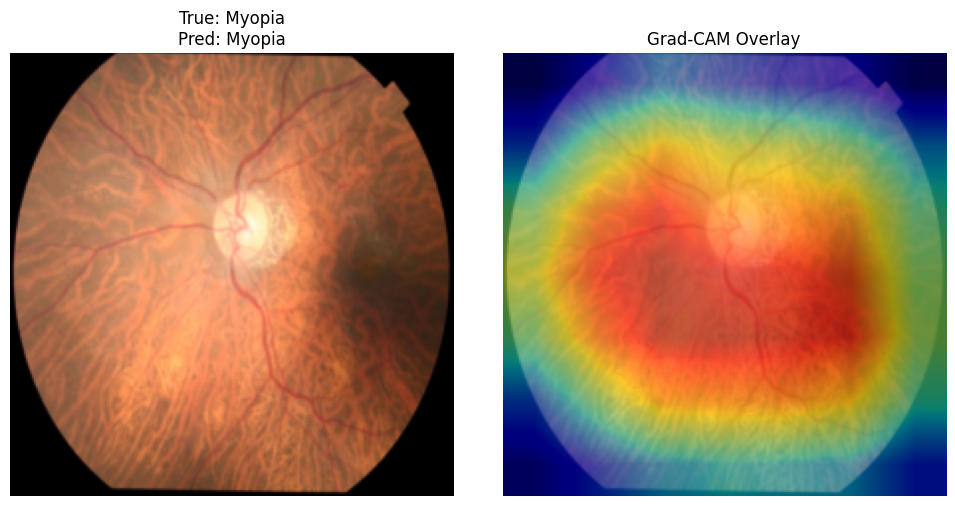

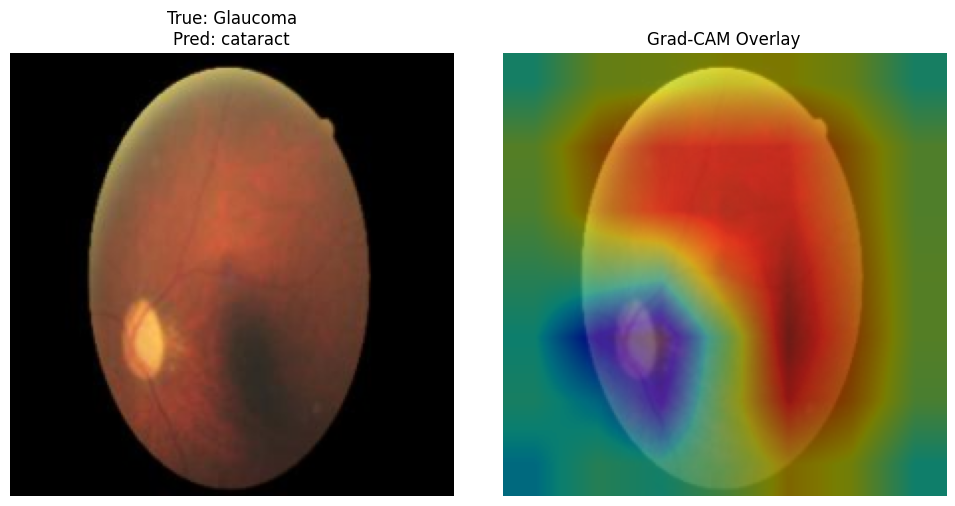

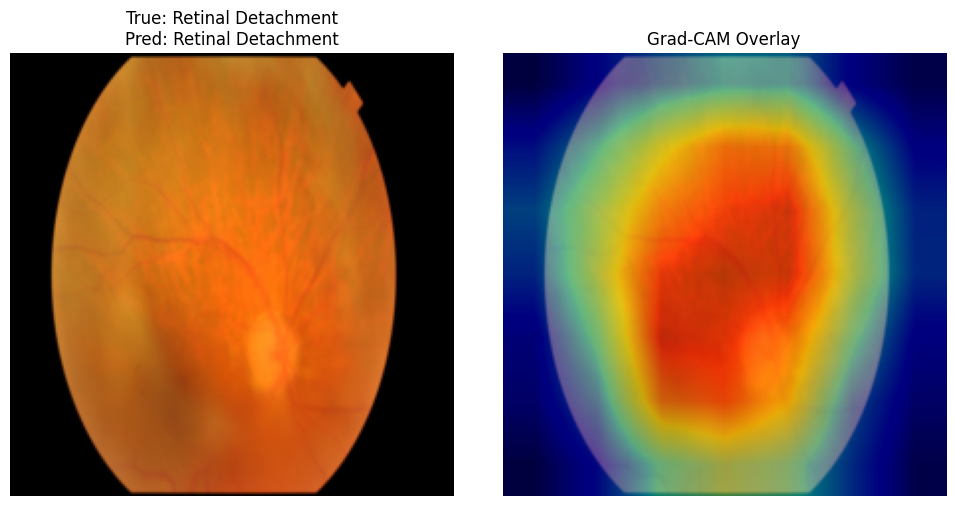

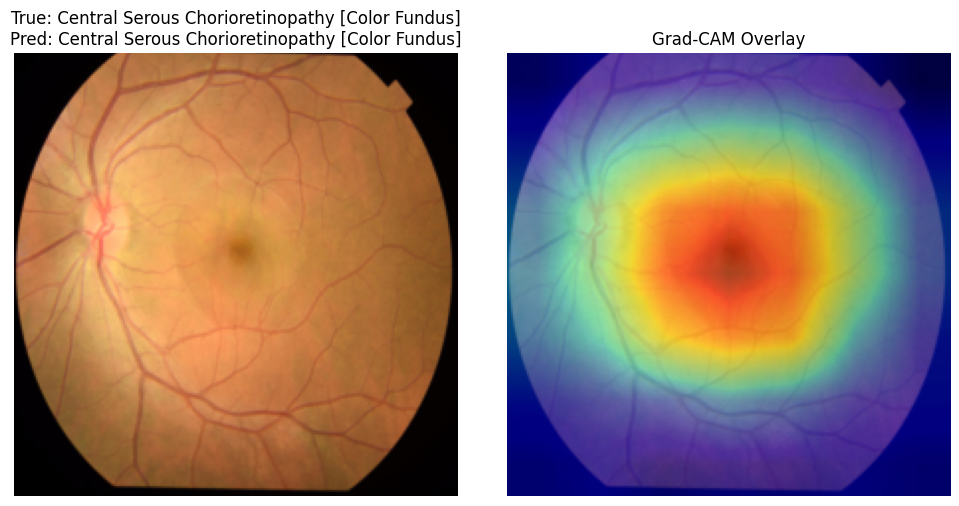

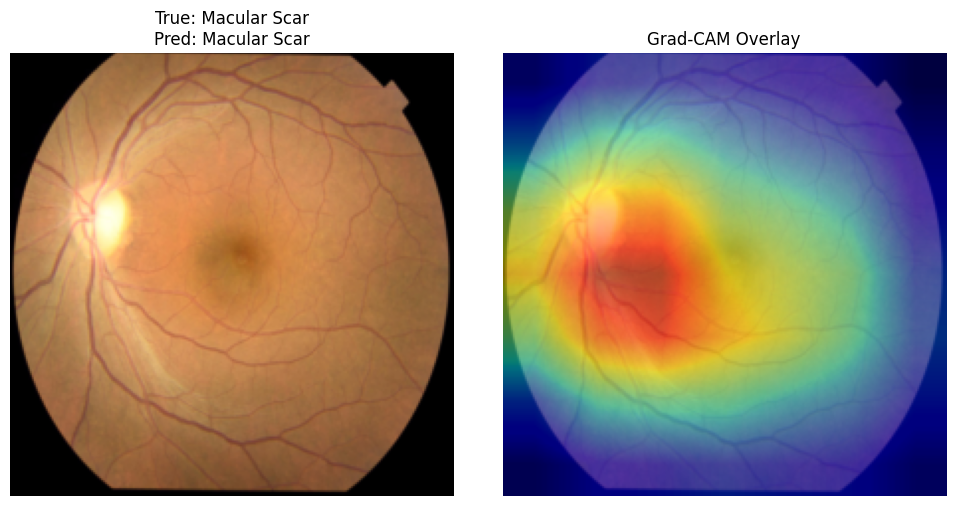

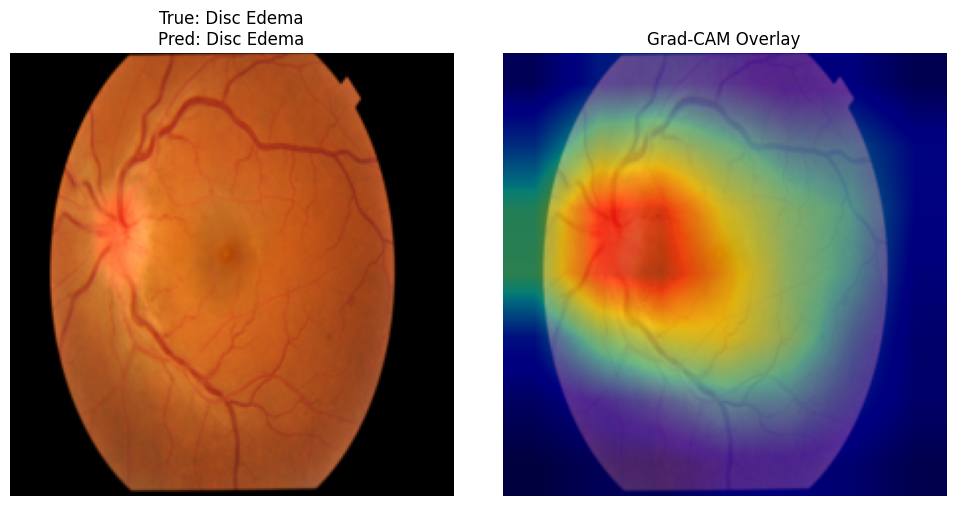

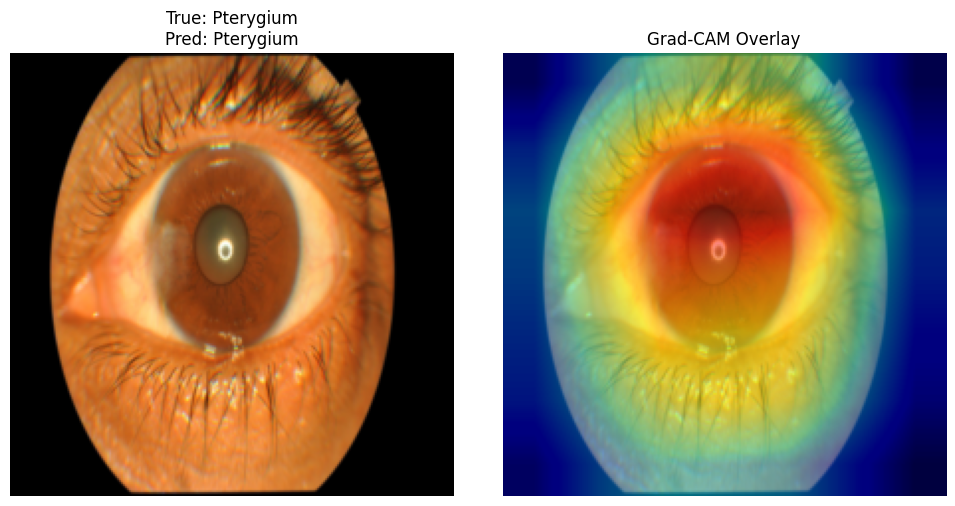

Grad-CAM explanations generated and saved.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam
from torchvision.transforms.functional import normalize, resize, to_pil_image
import os

# Ensure the best model is loaded and in evaluation mode
model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
model.eval()  # Set the model to evaluation mode

# Define the target layer for Grad-CAM
# For EfficientNetB0, the last convolutional layer before the classifier is typically in 'blocks[-1][-1].conv_pwl'
# or a similar structure depending on the exact timm model version.
# Inspecting the model structure to find the correct layer:
# print(model)
target_layer = model.blocks[-1][-1].conv_pwl

# Instantiate LayerGradCam
explainer = LayerGradCam(model, target_layer)

# Select a few representative images from the test_dataset
# We'll try to get one of each class from the test set if available

# Dictionary to store one image per class for visualization
representative_images = {}

# Map class index to class name for display
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Iterate through the test_dataset to find representative images
for i in range(len(test_dataset)):
    original_idx = test_dataset.indices[i]
    _, label = full_dataset[original_idx]
    if label not in representative_images:
        # Store the index in the original full_dataset and the transformed input
        representative_images[label] = {
            'original_image_idx': original_idx,
            'true_label': label,
            'input_tensor': val_test_transforms(full_dataset[original_idx][0]) # Apply val_test_transforms here
        }
    if len(representative_images) == NUM_CLASSES: # Stop if we have one for each class
        break

# Ensure all classes are covered, if not, fill in with available images
# (This part is mostly for robust demonstration, ideally all classes are in test set)
if len(representative_images) < NUM_CLASSES:
    print("Warning: Not all classes found in representative samples from test set.")

print(f"Generating Grad-CAM explanations for {len(representative_images)} representative images...")

# Generate and plot Grad-CAM explanations
for class_idx, img_info in representative_images.items():
    original_image_idx = img_info['original_image_idx']
    true_label_idx = img_info['true_label']
    input_tensor = img_info['input_tensor'].unsqueeze(0).to(device) # Add batch dimension and move to device

    # Get model's prediction for the image
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_label_idx = torch.max(outputs, 1)
        predicted_label_idx = predicted_label_idx.item()

    # Compute Grad-CAM attributions
    # We attribute with respect to the predicted class for general explanations
    attributions = explainer.attribute(input_tensor, target=predicted_label_idx)

    # Process attributions for visualization
    attributions_np = attributions.squeeze().cpu().detach().numpy() # Add .detach() here
    attributions_resized = resize(torch.from_numpy(attributions_np).unsqueeze(0).unsqueeze(0), (IMAGE_SIZE, IMAGE_SIZE)).squeeze().numpy()
    attributions_normalized = (attributions_resized - attributions_resized.min()) / (attributions_resized.max() - attributions_resized.min() + 1e-8)

    # Denormalize and prepare original image for plotting
    # Assuming IMAGENET_MEAN and IMAGENET_STD are defined globally
    original_image = full_dataset[original_image_idx][0] # Get raw PIL image before any transform
    img_to_plot = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))(original_image) # Resize to model input size
    img_to_plot = np.asarray(img_to_plot)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    ax[0].imshow(img_to_plot)
    ax[0].set_title(f"True: {idx_to_class[true_label_idx]}\nPred: {idx_to_class[predicted_label_idx]}")
    ax[0].axis('off')

    # Grad-CAM overlay
    ax[1].imshow(img_to_plot)
    ax[1].imshow(attributions_normalized, cmap='jet', alpha=0.5)
    ax[1].set_title(f"Grad-CAM Overlay")
    ax[1].axis('off')

    plt.tight_layout()
    # Save the plot
    output_filename = f"grad_cam_class_{idx_to_class[class_idx].replace(' ', '_').replace('[', '').replace(']', '')}.png"
    plt.savefig(os.path.join(RESULTS_DIR, output_filename))
    plt.show()
    plt.close(fig)

print("Grad-CAM explanations generated and saved.")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam
from torchvision.transforms.functional import normalize, resize, to_pil_image
import os

# Ensure the best model is loaded and in evaluation mode
model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
model.eval()  # Set the model to evaluation mode

# Define the target layer for Grad-CAM
# For EfficientNetB0, the last convolutional layer before the classifier is typically in 'blocks[-1][-1].conv_pwl'
# or a similar structure depending on the exact timm model version.
# Inspecting the model structure to find the correct layer:
# print(model)
target_layer = model.blocks[-1][-1].conv_pwl

# Instantiate LayerGradCam
explainer = LayerGradCam(model, target_layer)

# Select a few representative images from the test_dataset
# We'll try to get one of each class from the test set if available

# Dictionary to store one image per class for visualization
representative_images = {}

# Map class index to class name for display
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Iterate through the test_dataset to find representative images
for i in range(len(test_dataset)):
    original_idx = test_dataset.indices[i]
    _, label = full_dataset[original_idx]
    if label not in representative_images:
        # Store the index in the original full_dataset and the transformed input
        representative_images[label] = {
            'original_image_idx': original_idx,
            'true_label': label,
            'input_tensor': val_test_transforms(full_dataset[original_idx][0]) # Apply val_test_transforms here
        }
    if len(representative_images) == NUM_CLASSES: # Stop if we have one for each class
        break

# Ensure all classes are covered, if not, fill in with available images
# (This part is mostly for robust demonstration, ideally all classes are in test set)
if len(representative_images) < NUM_CLASSES:
    print("Warning: Not all classes found in representative samples from test set.")

print(f"Generating Grad-CAM explanations for {len(representative_images)} representative images...")

# Generate and plot Grad-CAM explanations
for class_idx, img_info in representative_images.items():
    original_image_idx = img_info['original_image_idx']
    true_label_idx = img_info['true_label']
    input_tensor = img_info['input_tensor'].unsqueeze(0).to(device) # Add batch dimension and move to device

    # Get model's prediction for the image
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_label_idx = torch.max(outputs, 1)
        predicted_label_idx = predicted_label_idx.item()

    # Compute Grad-CAM attributions
    # We attribute with respect to the predicted class for general explanations
    attributions = explainer.attribute(input_tensor, target=predicted_label_idx)

    # Process attributions for visualization
    attributions_np = attributions.squeeze().cpu().numpy() # Remove batch dim, move to CPU, convert to numpy
    attributions_resized = resize(torch.from_numpy(attributions_np).unsqueeze(0).unsqueeze(0), (IMAGE_SIZE, IMAGE_SIZE)).squeeze().numpy()
    attributions_normalized = (attributions_resized - attributions_resized.min()) / (attributions_resized.max() - attributions_resized.min() + 1e-8)

    # Denormalize and prepare original image for plotting
    # Assuming IMAGENET_MEAN and IMAGENET_STD are defined globally
    original_image = full_dataset[original_image_idx][0] # Get raw PIL image before any transform
    img_to_plot = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))(original_image) # Resize to model input size
    img_to_plot = np.asarray(img_to_plot)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    ax[0].imshow(img_to_plot)
    ax[0].set_title(f"True: {idx_to_class[true_label_idx]}\nPred: {idx_to_class[predicted_label_idx]}")
    ax[0].axis('off')

    # Grad-CAM overlay
    ax[1].imshow(img_to_plot)
    ax[1].imshow(attributions_normalized, cmap='jet', alpha=0.5)
    ax[1].set_title(f"Grad-CAM Overlay")
    ax[1].axis('off')

    plt.tight_layout()
    # Save the plot
    output_filename = f"grad_cam_class_{idx_to_class[class_idx].replace(' ', '_').replace('[', '').replace(']', '')}.png"
    plt.savefig(os.path.join(RESULTS_DIR, output_filename))
    plt.show()
    plt.close(fig)

print("Grad-CAM explanations generated and saved.")


Generating Grad-CAM explanations for 11 representative images...


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

Generating Grad-CAM explanations for 11 representative images...


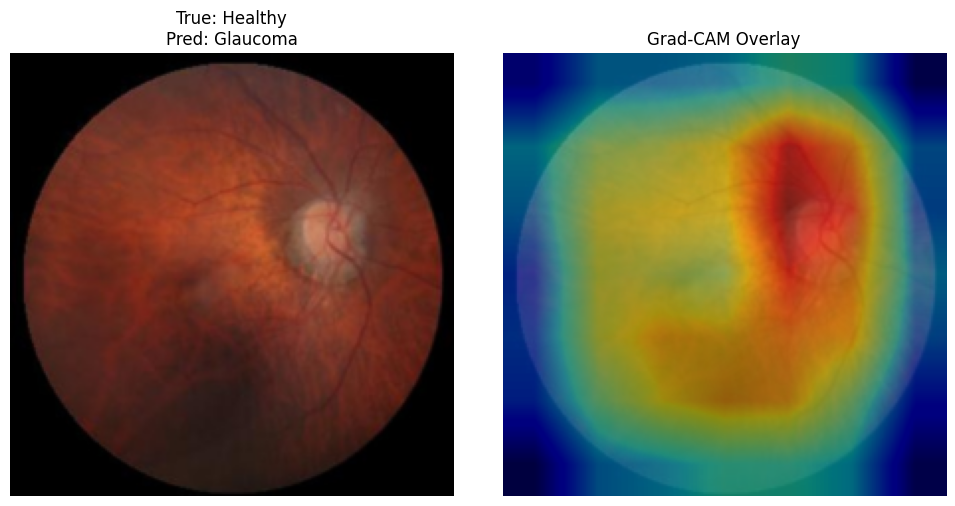

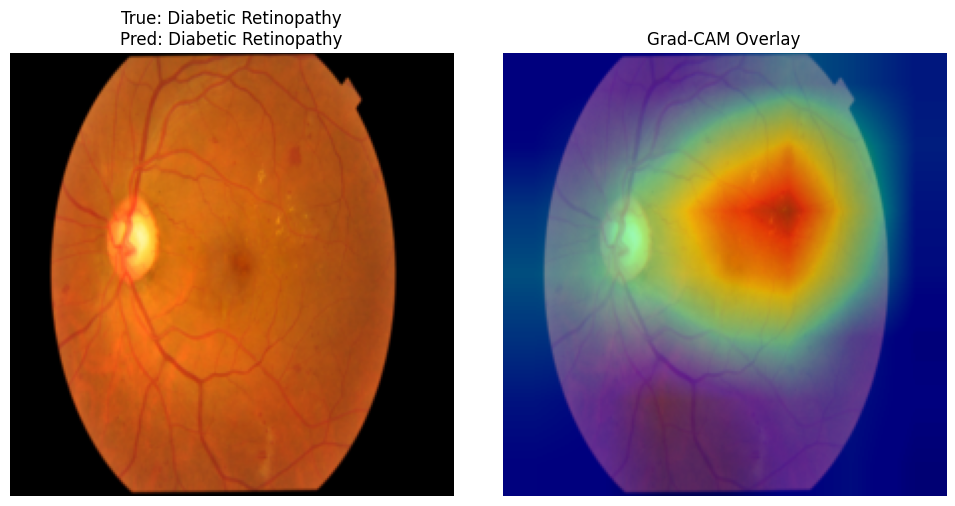

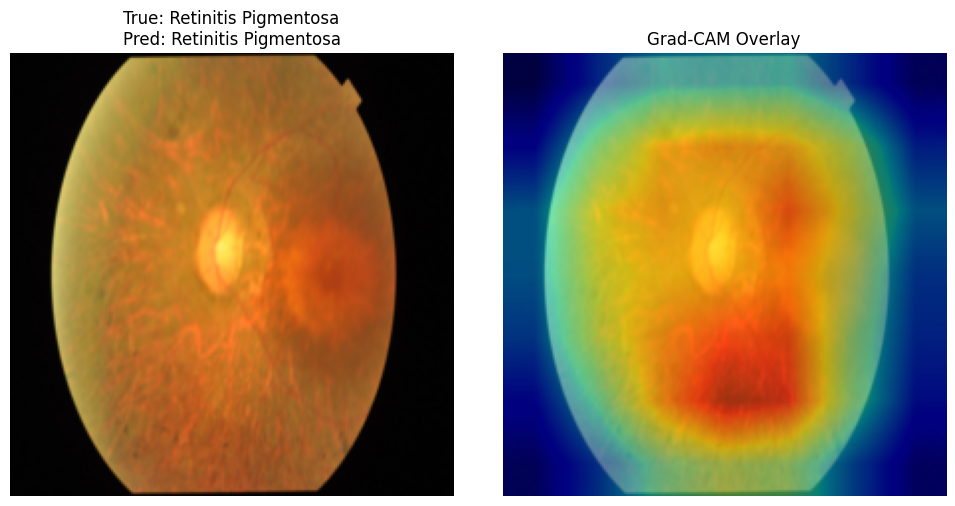

KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam
from torchvision.transforms.functional import normalize, resize, to_pil_image
import os

# Ensure the best model is loaded and in evaluation mode
model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
model.eval()  # Set the model to evaluation mode

# Define the target layer for Grad-CAM
# For EfficientNetB0, the last convolutional layer before the classifier is typically in 'blocks[-1][-1].conv_pwl'
# or a similar structure depending on the exact timm model version.
# Inspecting the model structure to find the correct layer:
# print(model)
target_layer = model.blocks[-1][-1].conv_pwl

# Instantiate LayerGradCam
explainer = LayerGradCam(model, target_layer)

# Select a few representative images from the test_dataset
# We'll try to get one of each class from the test set if available

# Dictionary to store one image per class for visualization
representative_images = {}

# Map class index to class name for display
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Iterate through the test_dataset to find representative images
for i in range(len(test_dataset)):
    original_idx = test_dataset.indices[i]
    _, label = full_dataset[original_idx]
    if label not in representative_images:
        # Store the index in the original full_dataset and the transformed input
        representative_images[label] = {
            'original_image_idx': original_idx,
            'true_label': label,
            'input_tensor': val_test_transforms(full_dataset[original_idx][0]) # Apply val_test_transforms here
        }
    if len(representative_images) == NUM_CLASSES: # Stop if we have one for each class
        break

# Ensure all classes are covered, if not, fill in with available images
# (This part is mostly for robust demonstration, ideally all classes are in test set)
if len(representative_images) < NUM_CLASSES:
    print("Warning: Not all classes found in representative samples from test set.")

print(f"Generating Grad-CAM explanations for {len(representative_images)} representative images...")

# Generate and plot Grad-CAM explanations
for class_idx, img_info in representative_images.items():
    original_image_idx = img_info['original_image_idx']
    true_label_idx = img_info['true_label']
    input_tensor = img_info['input_tensor'].unsqueeze(0).to(device) # Add batch dimension and move to device

    # Get model's prediction for the image
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_label_idx = torch.max(outputs, 1)
        predicted_label_idx = predicted_label_idx.item()

    # Compute Grad-CAM attributions
    # We attribute with respect to the predicted class for general explanations
    attributions = explainer.attribute(input_tensor, target=predicted_label_idx)

    # Process attributions for visualization
    attributions_np = attributions.squeeze().cpu().detach().numpy() # Add .detach() here
    attributions_resized = resize(torch.from_numpy(attributions_np).unsqueeze(0).unsqueeze(0), (IMAGE_SIZE, IMAGE_SIZE)).squeeze().numpy()
    attributions_normalized = (attributions_resized - attributions_resized.min()) / (attributions_resized.max() - attributions_resized.min() + 1e-8)

    # Denormalize and prepare original image for plotting
    # Assuming IMAGENET_MEAN and IMAGENET_STD are defined globally
    original_image = full_dataset[original_image_idx][0] # Get raw PIL image before any transform
    img_to_plot = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))(original_image) # Resize to model input size
    img_to_plot = np.asarray(img_to_plot)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    ax[0].imshow(img_to_plot)
    ax[0].set_title(f"True: {idx_to_class[true_label_idx]}\nPred: {idx_to_class[predicted_label_idx]}")
    ax[0].axis('off')

    # Grad-CAM overlay
    ax[1].imshow(img_to_plot)
    ax[1].imshow(attributions_normalized, cmap='jet', alpha=0.5)
    ax[1].set_title(f"Grad-CAM Overlay")
    ax[1].axis('off')

    plt.tight_layout()
    # Save the plot
    output_filename = f"grad_cam_class_{idx_to_class[class_idx].replace(' ', '_').replace('[', '').replace(']', '')}.png"
    plt.savefig(os.path.join(RESULTS_DIR, output_filename))
    plt.show()
    plt.close(fig)

print("Grad-CAM explanations generated and saved.")

# Task
Re-execute the Grad-CAM generation for representative images from the test set to highlight important regions in input images for model predictions. The code will be concise with minimal comments, and visualizations will be saved to the results directory.

```python
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam
from torchvision.transforms.functional import normalize, resize, to_pil_image
import os

# Ensure the best model is loaded and in evaluation mode
model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
model.eval()  # Set the model to evaluation mode

# Define the target layer for Grad-CAM
target_layer = model.blocks[-1][-1].conv_pwl

# Instantiate LayerGradCam
explainer = LayerGradCam(model, target_layer)

# Select a few representative images from the test_dataset
# We'll try to get one of each class from the test set if available

# Dictionary to store one image per class for visualization
representative_images = {}

# Map class index to class name for display
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Iterate through the test_dataset to find representative images
for i in range(len(test_dataset)):
    original_idx = test_dataset.indices[i]
    _, label = full_dataset[original_idx]
    if label not in representative_images:
        # Store the index in the original full_dataset and the transformed input
        representative_images[label] = {
            'original_image_idx': original_idx,
            'true_label': label,
            'input_tensor': val_test_transforms(full_dataset[original_idx][0]) # Apply val_test_transforms here
        }
    if len(representative_images) == NUM_CLASSES: # Stop if we have one for each class
        break

# Ensure all classes are covered, if not, fill in with available images
if len(representative_images) < NUM_CLASSES:
    print("Warning: Not all classes found in representative samples from test set.")

print(f"Generating Grad-CAM explanations for {len(representative_images)} representative images...")

# Generate and plot Grad-CAM explanations
for class_idx, img_info in representative_images.items():
    original_image_idx = img_info['original_image_idx']
    true_label_idx = img_info['true_label']
    input_tensor = img_info['input_tensor'].unsqueeze(0).to(device) # Add batch dimension and move to device

    # Get model's prediction for the image
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_label_idx = torch.max(outputs, 1)
        predicted_label_idx = predicted_label_idx.item()

    # Compute Grad-CAM attributions
    attributions = explainer.attribute(input_tensor, target=predicted_label_idx)

    # Process attributions for visualization
    attributions_np = attributions.squeeze().cpu().detach().numpy() # Add .detach() here
    attributions_resized = resize(torch.from_numpy(attributions_np).unsqueeze(0).unsqueeze(0), (IMAGE_SIZE, IMAGE_SIZE)).squeeze().numpy()
    attributions_normalized = (attributions_resized - attributions_resized.min()) / (attributions_resized.max() - attributions_resized.min() + 1e-8)

    # Denormalize and prepare original image for plotting
    original_image = full_dataset[original_image_idx][0] # Get raw PIL image before any transform
    img_to_plot = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))(original_image) # Resize to model input size
    img_to_plot = np.asarray(img_to_plot)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    ax[0].imshow(img_to_plot)
    ax[0].set_title(f"True: {idx_to_class[true_label_idx]}\nPred: {idx_to_class[predicted_label_idx]}")
    ax[0].axis('off')

    # Grad-CAM overlay
    ax[1].imshow(img_to_plot)
    ax[1].imshow(attributions_normalized, cmap='jet', alpha=0.5)
    ax[1].set_title(f"Grad-CAM Overlay")
    ax[1].axis('off')

    plt.tight_layout()
    # Save the plot
    output_filename = f"grad_cam_class_{idx_to_class[class_idx].replace(' ', '_').replace('[', '').replace(']', '')}.png"
    plt.savefig(os.path.join(RESULTS_DIR, output_filename))
    plt.show()
    plt.close(fig)

print("Grad-CAM explanations generated and saved.")
```

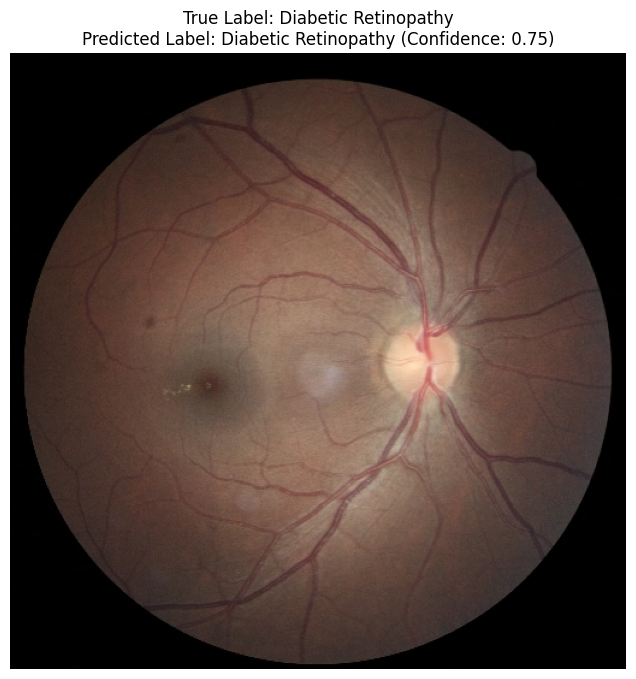

Diagnosing random image: 11241_right.jpeg
True Disease: Diabetic Retinopathy
Predicted Disease: Diabetic Retinopathy
Confidence: 0.7497


In [ ]:
import torch
import random
from PIL import Image
import matplotlib.pyplot as plt

# Ensure the best model is loaded and in evaluation mode
model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
model.eval()  # Set the model to evaluation mode

# Select a random image from the test_dataset for diagnosis
random_index = random.randint(0, len(test_dataset) - 1)

# Get the original untransformed image and its true label
original_image_path, true_label_for_diagnosis = full_dataset.samples[test_dataset.indices[random_index]]
original_image = Image.open(original_image_path).convert('RGB')

# Apply the validation/test transformations to get a tensor
input_tensor_for_diagnosis = val_test_transforms(original_image)

# Add batch dimension and move to device for prediction
input_tensor_for_diagnosis = input_tensor_for_diagnosis.unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    outputs = model(input_tensor_for_diagnosis)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predicted_class_idx = torch.max(outputs, 1)

predicted_class_name = idx_to_class[predicted_class_idx.item()]
true_class_name = idx_to_class[true_label_for_diagnosis]

# Display the image and prediction
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name} (Confidence: {probabilities[0, predicted_class_idx.item()]:.2f})")
plt.axis('off')
plt.show()
print(f"Diagnosing random image: {os.path.basename(original_image_path)}")
print(f"True Disease: {true_class_name}")
print(f"Predicted Disease: {predicted_class_name}")
print(f"Confidence: {probabilities[0, predicted_class_idx.item()]:.4f}")


## Diagnose Specific Image from Path

### Subtask:
Load a specific image from a given path, preprocess it, and use the trained model to predict the disease.


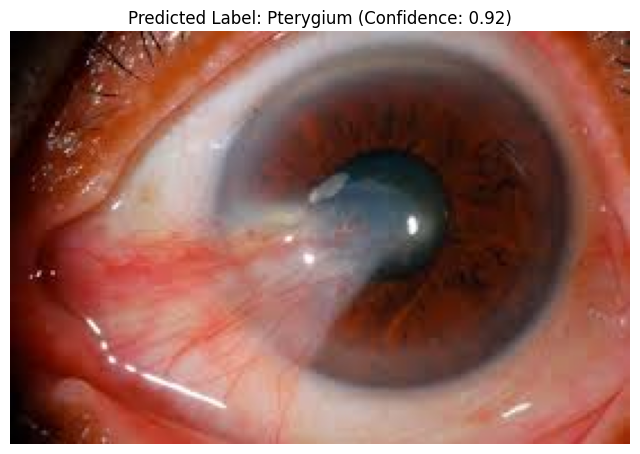

Diagnosing image: download (2).jpg
Predicted Disease: Pterygium
Confidence: 0.9244


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os


model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
model.eval()


specific_image_path = '/content/download (2).jpg'


try:
    specific_image = Image.open(specific_image_path).convert('RGB')
except FileNotFoundError:
    print(f"Error: Image not found at {specific_image_path}")

    raise


input_tensor_for_diagnosis = val_test_transforms(specific_image)


input_tensor_for_diagnosis = input_tensor_for_diagnosis.unsqueeze(0).to(device)


with torch.no_grad():
    outputs = model(input_tensor_for_diagnosis)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predicted_class_idx = torch.max(outputs, 1)

predicted_class_name = idx_to_class[predicted_class_idx.item()]


plt.figure(figsize=(8, 8))
plt.imshow(specific_image)
plt.title(f"Predicted Label: {predicted_class_name} (Confidence: {probabilities[0, predicted_class_idx.item()]:.2f})")
plt.axis('off')
plt.show()
print(f"Diagnosing image: {os.path.basename(specific_image_path)}")
print(f"Predicted Disease: {predicted_class_name}")
print(f"Confidence: {probabilities[0, predicted_class_idx.item()]:.4f}")


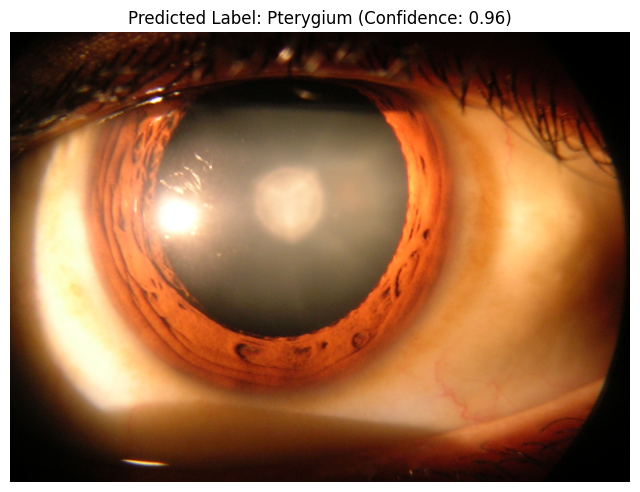

Diagnosing image: Cataract_in_human_eye.png
Predicted Disease: Pterygium
Confidence: 0.9626


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os


model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
model.eval()


specific_image_path = '/content/Cataract_in_human_eye.png'


try:
    specific_image = Image.open(specific_image_path).convert('RGB')
except FileNotFoundError:
    print(f"Error: Image not found at {specific_image_path}")

    raise


input_tensor_for_diagnosis = val_test_transforms(specific_image)


input_tensor_for_diagnosis = input_tensor_for_diagnosis.unsqueeze(0).to(device)


with torch.no_grad():
    outputs = model(input_tensor_for_diagnosis)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predicted_class_idx = torch.max(outputs, 1)

predicted_class_name = idx_to_class[predicted_class_idx.item()]


plt.figure(figsize=(8, 8))
plt.imshow(specific_image)
plt.title(f"Predicted Label: {predicted_class_name} (Confidence: {probabilities[0, predicted_class_idx.item()]:.2f})")
plt.axis('off')
plt.show()
print(f"Diagnosing image: {os.path.basename(specific_image_path)}")
print(f"Predicted Disease: {predicted_class_name}")
print(f"Confidence: {probabilities[0, predicted_class_idx.item()]:.4f}")

## Diagnose Specific Image from Path

### Subtask:
Load a specific image from a given path, preprocess it, and use the trained model to predict the disease.


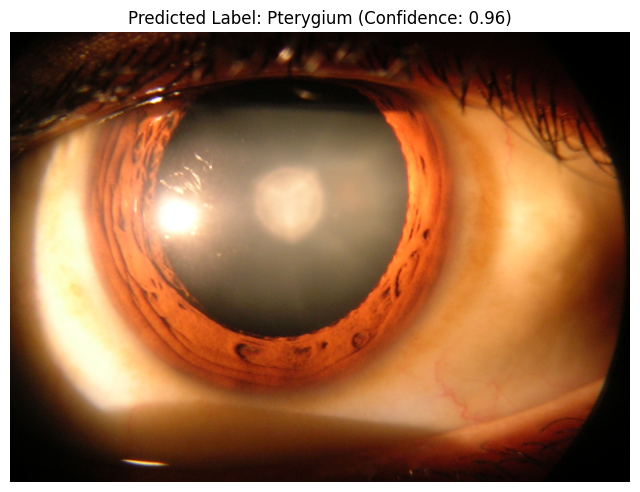

Diagnosing image: Cataract_in_human_eye.png
Predicted Disease: Pterygium
Confidence: 0.9626


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os

# Ensure the best model is loaded and in evaluation mode
model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
model.eval()

# Define the path to the specific image
specific_image_path = '/content/Cataract_in_human_eye.png'

# Load the image
try:
    specific_image = Image.open(specific_image_path).convert('RGB')
except FileNotFoundError:
    print(f"Error: Image not found at {specific_image_path}")
    # Optionally, you can raise the exception or handle it differently
    raise

# Apply the validation/test transformations to get a tensor
input_tensor_for_diagnosis = val_test_transforms(specific_image)

# Add batch dimension and move to device for prediction
input_tensor_for_diagnosis = input_tensor_for_diagnosis.unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    outputs = model(input_tensor_for_diagnosis)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predicted_class_idx = torch.max(outputs, 1)

predicted_class_name = idx_to_class[predicted_class_idx.item()]

# Display the image and prediction
plt.figure(figsize=(8, 8))
plt.imshow(specific_image)
plt.title(f"Predicted Label: {predicted_class_name} (Confidence: {probabilities[0, predicted_class_idx.item()]:.2f})")
plt.axis('off')
plt.show()
print(f"Diagnosing image: {os.path.basename(specific_image_path)}")
print(f"Predicted Disease: {predicted_class_name}")
print(f"Confidence: {probabilities[0, predicted_class_idx.item()]:.4f}")